# Air Pollution Tutorial
Featured on Jason Brownlee's *Machine Learning Mastery* blog [here](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)

In [1]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
# Silence TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any in {'0', '1', '2'}
import tensorflow as tf


In [3]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv, DataFrame, concat
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [4]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [5]:
%%bash
ls -alh

total 8920
drwxr-xr-x  11 jvincen7  MS\Domain Users   352B Mar  1 10:43 .
drwxr-xr-x  11 jvincen7  MS\Domain Users   352B Mar  1 10:12 ..
drwxr-xr-x   3 jvincen7  MS\Domain Users    96B Mar  1 10:31 .ipynb_checkpoints
-rw-r--r--   1 jvincen7  MS\Domain Users   1.9K Mar  1 10:29 csv_builder.ipynb
-rw-r--r--   1 jvincen7  MS\Domain Users   676B Mar  1 10:08 csv_builder.py
-rw-r--r--   1 jvincen7  MS\Domain Users   149K Mar  1 10:29 data_eda.ipynb
-rw-r--r--   1 jvincen7  MS\Domain Users   470B Feb  8  2018 data_eda.py
-rw-r--r--   1 jvincen7  MS\Domain Users    37K Mar  1 10:43 lstm_data_prep.ipynb
-rw-r--r--   1 jvincen7  MS\Domain Users   3.4K Jun  6  2018 lstm_data_prep.py
-rw-r--r--   1 jvincen7  MS\Domain Users   2.2M Mar  1 10:08 pollution.csv
-rw-r--r--   1 jvincen7  MS\Domain Users   1.9M Feb  8  2018 raw.csv


In [6]:
# load dataset
# os.chdir('../')
dataset = read_csv('./pollution.csv', header=0, index_col=0)
values = dataset.values


In [7]:
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

In [8]:
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

reframed.head()


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


In [9]:
# split into train and test sets
# Using n_train_hours, we are only training on the first 3 years of data (365*24*3), and evaluating on the other 1
values = reframed.values
n_train_hours = 365 * 24 * 3
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(26280, 1, 8) (26280,) (17519, 1, 8) (17519,)


In [11]:
%%notify
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 26280 samples, validate on 17519 samples
Epoch 1/50
26280/26280 [==============================] - 3s 122us/step - loss: 0.0420 - val_loss: 0.0608
Epoch 2/50
26280/26280 [==============================] - 4s 134us/step - loss: 0.0181 - val_loss: 0.0294
Epoch 3/50
26280/26280 [==============================] - 4s 139us/step - loss: 0.0151 - val_loss: 0.0192
Epoch 4/50
26280/26280 [==============================] - 3s 104us/step - loss: 0.0140 - val_loss: 0.0149
Epoch 5/50
26280/26280 [==============================] - 3s 125us/step - loss: 0.0138 - val_loss: 0.0154
Epoch 6/50
26280/26280 [==============================] - 3s 110us/step - loss: 0.0138 - val_loss: 0.0156
Epoch 7/50
26280/26280 [==============================] - 2s 89us/step - loss: 0.0138 - val_loss: 0.0157
Epoch 8/50
26280/26280 [==============================] - 2s 90us/step - loss: 0.0138 - val_loss: 0.0157
Epoch 9/50
26280/26280 [==============================] - 2s 91us/step - loss: 0.0139 - val_loss: 0.0155

<IPython.core.display.Javascript object>

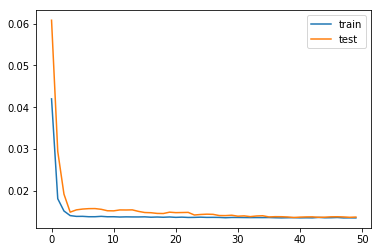

In [12]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [13]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


In [14]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]


In [15]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


In [16]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 26.730
